In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



In [ ]:
# Training
def train(epoch, num_epochs):
    global train_accuracy_list

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calculate training accuracy
    train_accuracy = 100.*correct/total
    train_accuracy_list.append(train_accuracy)
    print(f'Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss}, Train Acc: {(correct/total)*100}')
    return train_loss


In [ ]:
def test(epoch, num_epochs):
    global best_acc, test_accuracy_list
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Calculate test accuracy
    test_accuracy = 100.*correct/total
    test_accuracy_list.append(test_accuracy)
    print(f'Epoch: {epoch}/{num_epochs}, Test Loss: {test_loss}, Test Acc: {(correct/total)*100}')
     # Save checkpoint
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    return test_loss

In [ ]:
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Model
print('==> Building model..')
net = Net()  # Using the Net class we defined earlier
net = net.to(device)

# Optimizer and Scheduler
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.1, weight_decay=5e-4)

# Criterion
criterion = nn.NLLLoss()

train_accuracy_list = []
test_accuracy_list = []


# Training loop
y_pred_all=[]
y_true_all=[]

train_loss = []
test_loss = []
num_epochs=101
for epoch in range(start_epoch, num_epochs):
    train_loss.append(train(epoch,num_epochs))
    test_loss.append(test(epoch,num_epochs))
    with torch.no_grad():
        net.eval()
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred_all.extend(predicted.cpu().numpy())
            y_true_all.extend(targets.cpu().numpy())


==> Preparing data..


100%|██████████| 170498071/170498071 [00:02<00:00, 61858166.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
==> Building model..


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0/101, Train Loss: 772.6272084712982, Train Acc: 26.476
Epoch: 0/101, Test Loss: 162.7314337491989, Test Acc: 38.89
Saving..
Epoch: 1/101, Train Loss: 647.3094240427017, Train Acc: 39.328
Epoch: 1/101, Test Loss: 147.17858612537384, Test Acc: 45.050000000000004
Saving..
Epoch: 2/101, Train Loss: 585.6506816148758, Train Acc: 45.986
Epoch: 2/101, Test Loss: 126.28304421901703, Test Acc: 54.010000000000005
Saving..
Epoch: 3/101, Train Loss: 540.8751629590988, Train Acc: 50.614000000000004
Epoch: 3/101, Test Loss: 117.78357112407684, Test Acc: 58.76
Saving..
Epoch: 4/101, Train Loss: 509.4472748041153, Train Acc: 54.188
Epoch: 4/101, Test Loss: 108.19414323568344, Test Acc: 61.14000000000001
Saving..
Epoch: 5/101, Train Loss: 475.8131203651428, Train Acc: 56.98800000000001
Epoch: 5/101, Test Loss: 103.06295794248581, Test Acc: 63.9
Saving..
Epoch: 6/101, Train Loss: 450.40689408779144, Train Acc: 59.558
Epoch: 6/101, Test Loss: 95.72126513719559, Test Acc: 66.60000000000001
Saving.

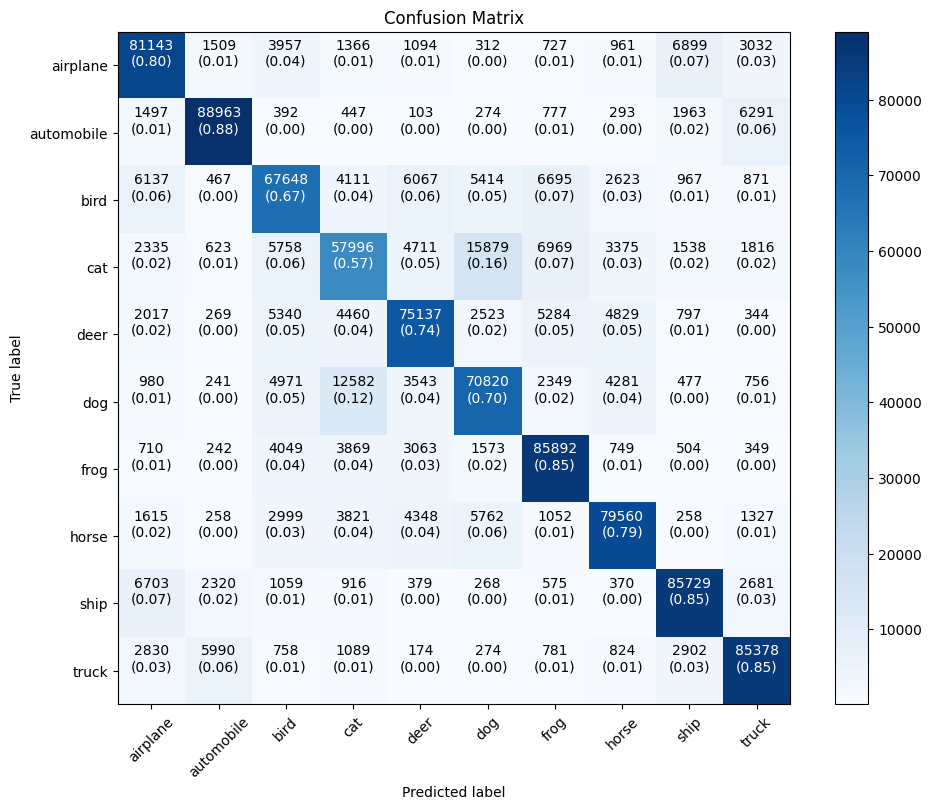

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Define classes (assuming CIFAR-10 classes)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Format and display the values
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import f1_score,precision_score

# Compute precision
precision = precision_score(y_true_all, y_pred_all, average='weighted')
print("Precision:", precision)

#F1 score
f1 = f1_score(y_true_all, y_pred_all, average='weighted')
print("F1 Score:", f1)

Precision: 0.7690440430629307
F1 Score: 0.7693202277355794


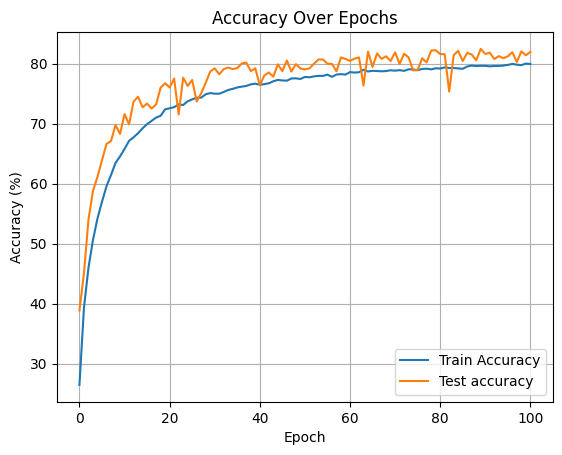

In [ ]:
plt.plot(range(start_epoch, num_epochs), train_accuracy_list, label='Train Accuracy')
plt.plot(range(start_epoch, num_epochs), test_accuracy_list, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

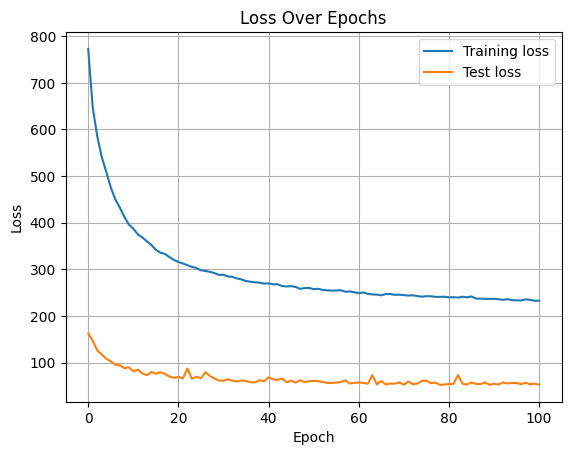

In [ ]:
plt.plot(range(start_epoch, num_epochs), train_loss, label='Training loss')
plt.plot(range(start_epoch, num_epochs), test_loss, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from torchvision.models import resnet18
def create_resnet18():
    model = resnet18()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model

In [ ]:
net = create_resnet18()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.1, weight_decay=5e-4)

# Criterion
criterion = nn.CrossEntropyLoss()
train_accuracy_list = []
test_accuracy_list = []

y_pred_all=[]
y_true_all=[]
# Training loop
train_loss = []
test_loss = []
num_epochs=51
for epoch in range(start_epoch, num_epochs):
    train_loss.append(train(epoch,num_epochs))
    test_loss.append(test(epoch,num_epochs))
    with torch.no_grad():
        net.eval()
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred_all.extend(predicted.cpu().numpy())
            y_true_all.extend(targets.cpu().numpy())


Epoch: 0/51, Train Loss: 635.7179207801819, Train Acc: 42.272
Epoch: 0/51, Test Loss: 163.8665713071823, Test Acc: 45.75
Epoch: 1/51, Train Loss: 455.21608209609985, Train Acc: 57.972
Epoch: 1/51, Test Loss: 105.14367389678955, Test Acc: 62.68
Epoch: 2/51, Train Loss: 382.14820128679276, Train Acc: 65.278
Epoch: 2/51, Test Loss: 119.67542845010757, Test Acc: 60.86
Epoch: 3/51, Train Loss: 331.38529086112976, Train Acc: 70.004
Epoch: 3/51, Test Loss: 102.01774781942368, Test Acc: 64.96
Epoch: 4/51, Train Loss: 295.67669877409935, Train Acc: 73.56200000000001
Epoch: 4/51, Test Loss: 96.75288540124893, Test Acc: 68.73
Epoch: 5/51, Train Loss: 269.13331761956215, Train Acc: 76.048
Epoch: 5/51, Test Loss: 82.81010860204697, Test Acc: 72.48
Epoch: 6/51, Train Loss: 247.8759590089321, Train Acc: 78.05
Epoch: 6/51, Test Loss: 72.76639974117279, Test Acc: 75.66000000000001
Epoch: 7/51, Train Loss: 232.6676880121231, Train Acc: 79.262
Epoch: 7/51, Test Loss: 67.94688990712166, Test Acc: 77.09
Ep

In [ ]:
from sklearn.metrics import f1_score,precision_score

# Compute precision
precision = precision_score(y_true_all, y_pred_all, average='weighted')
print("Precision:", precision)

#F1 score
f1 = f1_score(y_true_all, y_pred_all, average='weighted')
print("F1 Score:", f1)

Precision: 0.8067068180022818
F1 Score: 0.8065885415680043


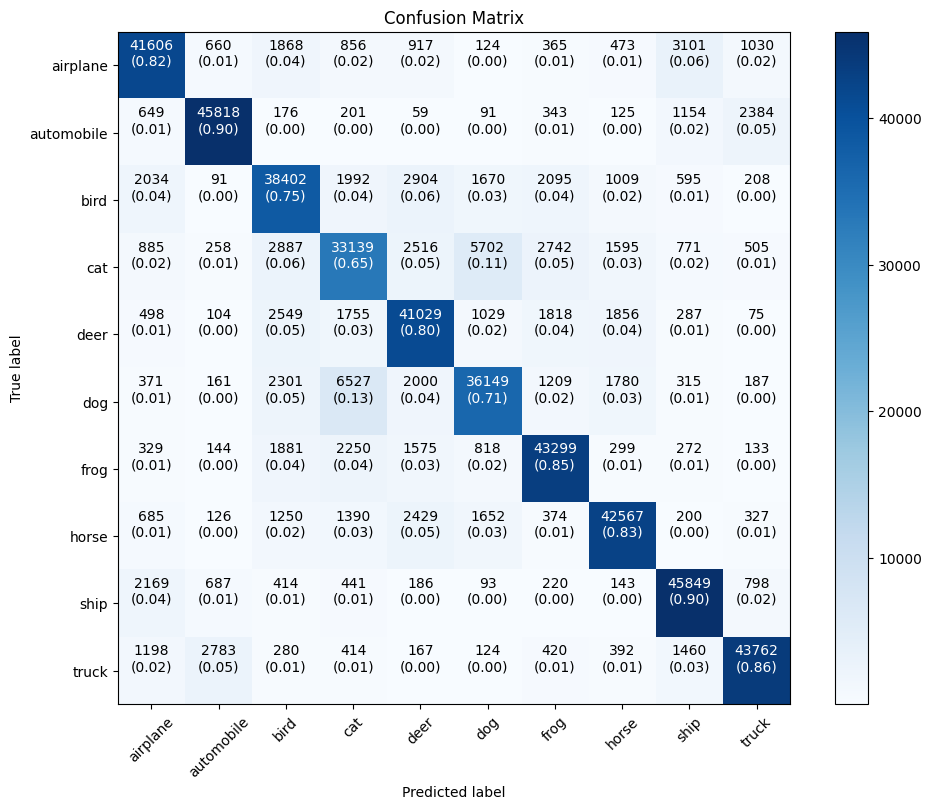

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Define classes (assuming CIFAR-10 classes)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Format and display the values
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


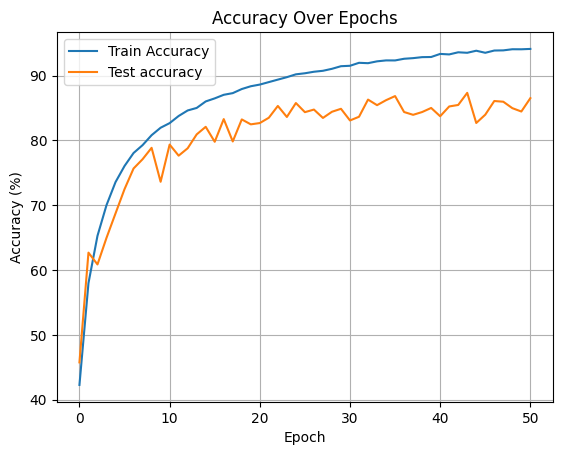

In [ ]:
plt.plot(range(start_epoch, num_epochs), train_accuracy_list, label='Train Accuracy')
plt.plot(range(start_epoch, num_epochs), test_accuracy_list, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

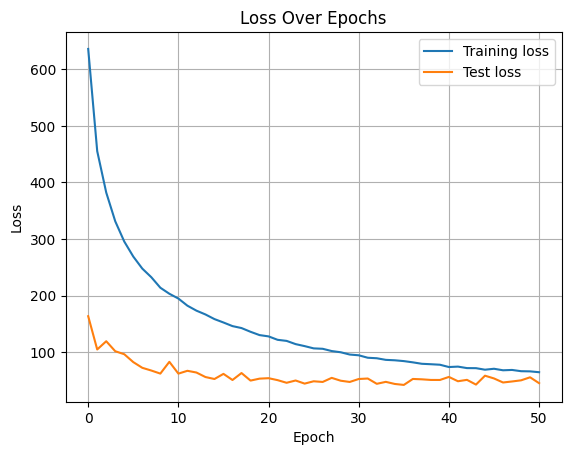

In [ ]:
plt.plot(range(start_epoch, num_epochs), train_loss, label='Training loss')
plt.plot(range(start_epoch, num_epochs), test_loss, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

